<a href="https://colab.research.google.com/github/Vesalon/xla-nmf/blob/main/notebooks/green_minimization_fides.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#!pip install fides

In [3]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", True)

import fides
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import numpy as np
import math
import time
import logging
import graphviz
from functools import partial
import sys
from matplotlib import pyplot as plt

In [4]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#       set true variables for generated observations       #
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

### parameters ###

# The amplitudes of the original sources
As = np.array([0.5, 0.7])
# positions of the source
Xs = np.array([
    [-0.1, -0.2],
    [-0.9, -0.8]
])

# Advection velocity
u_scaler = 0.05
# U = tf_c(np.array([0.05, 0]))
# Dispersivity
D = np.array([0.005, 0.00125])


### fixed known values ###

# the initial time the sources begin the release
Ts = -10.

# positions of the detectors
Xd = np.array([
    [0, 0],
    [-0.5, -0.5],
    [0.5, 0.5],
    [0.5, -0.5]
])
# time values of data
t = np.linspace(0, 20, 80)

# noise to add to 
noise_level = 1e-4

In [5]:
# Helpers - input shaping, generating bounds and initial points

def gen_flat_bounds(num_sources):
    upper_bounds = (
        1.5*np.ones(num_sources),
        np.ones((num_sources, 2)),
        np.ones(1),
        np.ones(2),
    )
    # instead of 0, use epsilon of 1e-10
    lower_bounds = (
        1e-10*np.ones(num_sources),
        -1*np.ones((num_sources, 2)),
        1e-10*np.ones(1),
        1e-10*np.ones(2),
    )
    upper_bounds, _ = flatten_inputs(*upper_bounds)
    lower_bounds, _ = flatten_inputs(*lower_bounds)
    return upper_bounds, lower_bounds

def gen_init(num_sources):
    return (
        np.random.rand(num_sources),
        2*(0.5 - np.random.rand(num_sources, 2)),
        np.random.rand(1),
        np.random.rand(2),
    )

def num_source2shapes(num_sources):
    sample_input = gen_init(num_sources)
    _, input_shapes = flatten_inputs(*sample_input)
    return input_shapes

def flatten_inputs(*inputs):
    flat = []
    shapes = []
    for input in inputs:
        shapes.append(input.shape)
        flat.extend(input.flatten())
    return np.array(flat), tuple(shapes)

def unflatten_inputs(flat_inputs, shapes):
    i = 0
    inputs = []
    for shape in shapes:
        size = np.prod(shape)
        inputs.append(np.reshape(flat_inputs[i:i+size], shape))
        i+=size
    return inputs


In [6]:
# green model functions using JAX

@partial(jax.jit, static_argnames=['length'])
def identity_vec(length):
    # returns vector that looks like [1 0 .. 0]
    return jnp.squeeze(jax.lax.slice(jnp.identity(length), (0, 0), (1, length)))

@jax.jit
def green(a_s, x_s, t_s, x_d, t, U, D):
    # make matrix nt x dims
    t_offset = t-t_s
    xx_s = jax.lax.broadcast_in_dim(x_s, (x_s.shape[0], t.shape[0]), (0,)).T
    xx_d = jax.lax.broadcast_in_dim(x_d, (x_d.shape[0], t.shape[0]), (0,)).T
    tt = jax.lax.broadcast_in_dim(t_offset, (x_s.shape[0], t.shape[0]), (1,)).T

    xx = xx_d - xx_s - U*tt
    gaussians = (-xx**2)
    gaussians = gaussians/(4*D*tt)
    gaussians = jnp.exp(gaussians)

    dividend = jnp.prod(D)
    dividend = jnp.sqrt(dividend)
    dividend = dividend*(t_offset)
    dividend = 4*math.pi*dividend

    res = a_s*jnp.prod(gaussians, axis=1)/dividend
    return res

green_detector_mapped = jax.vmap(
    green,
    in_axes=(None, None, None, 0, None, None, None)
)
green_matrix = jax.vmap(
    green_detector_mapped,
    in_axes=(0, 0, None, None, None, None, None)
)

@jax.jit
def reconstruct_general(A_s, X_s, T_s, X_d, t, U, D):
    U = U * identity_vec(D.shape[0])
    return jnp.transpose(jnp.sum(green_matrix(A_s, X_s, T_s, X_d, t, U, D), axis=0))


In [7]:
# set up partial functions to set up non-trainable values as constants for jax compilation and autodiff

def make_model_fn(T_s, X_d, t): # constants
    def model_fn(A_s, X_s, U, D): # parameters/model variables
        return reconstruct_general(A_s, X_s, T_s, X_d, t, U, D) # all inputs into original function
    return jax.jit(model_fn)

# need to set up flattening so that residual function has 1d array as both input and output (R^m -> R^n)

def make_flat_resids_fn(model_fn, observations, num_sources):
    input_shapes = num_source2shapes(num_sources)
    unflatten_func = jax.jit(partial(unflatten_inputs, shapes=input_shapes))
    def resid(flat_input):
        inputs = unflatten_func(flat_input)
        return jnp.ravel(model_fn(*inputs) - observations)
    return jax.jit(resid)

In [8]:
# Analysis functions - to be applied to the results dataframe returned by NMF runs

def filter_quantile(res, col_to_filter='fval', quantile=0.25):
    return res[
        res[col_to_filter] < res[col_to_filter].quantile(q=quantile)
    ]

def extract_point(sol, num_sources):
    # extract source amplitudes and positions to use as points for clustering
    points = []
    input_shapes = num_source2shapes(num_sources)
    sol = unflatten_inputs(sol, input_shapes)
    a = sol[0] # amplitudes
    x = sol[1] # locations
    for p in range(len(a)):
        point = [a[p]]
        point.extend(x[p])
        points.append(point)
    return points

def extract_points(res):
    res['points'] = res['sol'].apply(lambda x: extract_point(x, res['num_sources'].iloc[0]))
    return res

def AIC(sill_avg, recon, num_resids, num_sources, sill_cutoff=0.7):
    aic_scores = []
    if sill_avg > sill_cutoff:
        aic = 2*num_sources + num_resids*math.log(recon/num_resids)
    else:
        aic = np.inf
    return aic

def result_analysis(res, num_resids):
    num_sources = res['num_sources'].iloc[0]
    points = res['points'].sum()
    import pdb;pdb.set_trace()
    if num_sources == 1:
        centers = pd.DataFrame(points).mean().tolist()
        sill = 1
    else:
        kmeans = KMeans(
            init='random',
            n_clusters = num_sources,
            n_init=10,
            max_iter=300
        )
        kmeans.fit(points)
        centers = kmeans.cluster_centers_
        sill = silhouette_score(points, kmeans.labels_)

    recon = res['normF'].mean()
    aic_score = AIC(sill, recon, num_resids, num_sources)

    return pd.DataFrame({
        'num_source': [num_sources],
        'aic_score': [aic_score],
        'sillhouette_score': [sill],
        'reconstruction_loss': [recon],
        'centers': [centers]
    })


# NMF run

In [9]:
# generate observations from target variables with small noise

model_fn = make_model_fn(Ts, Xd, t)
observations = model_fn(As, Xs, np.array([u_scaler]), D)
noise = noise_level/2 - noise_level*np.random.rand(*observations.shape)
observations += noise

AA = 0 # some normalization factor to be used for AIC calculation later
for i in range(observations.shape[1]):
    AA += np.sum(observations[:, i]**2)

In [10]:
def setup_optimizer(num_sources):
    resid = jax.jit(make_flat_resids_fn(model_fn, observations, num_sources))
    resid_jac = jax.jit(jax.jacfwd(resid)) # explicitly set forward mode autodiff

    # return fval, grad, and (gauss_newton) hessian using resid and resid_jac functions
    def obj(x):
        r = resid(x)
        jac_r = resid_jac(x)
        loss = 0.5*jnp.sum(jnp.square(r))
        grad = jnp.matmul(r.T, jac_r)
        hess = jnp.matmul(jac_r.T, jac_r)
        return float(loss), np.asarray(grad), np.asarray(hess)

    ub, lb = gen_flat_bounds(num_sources)
    # fides optimizer object
    opt = fides.Optimizer(
        obj,
        ub=ub,
        lb=lb,
        options={
            'maxiter': 400,
            'xtol': 1e-6,
            'stepback_strategy': 'truncate',
            },
        verbose = logging.ERROR
    )

    return opt

In [11]:
# run NMF for up to max_num_sources

nsim=10
max_num_sources = 7

sill_avg = []
recon = []
all_results = pd.DataFrame(columns=['fval', 'sol', 'grad', 'hess', 'normF', 'num_sources'])
errors = []
for num_sources in range(1, max_num_sources+1):
# for num_sources in range(4, 5):
    ### define optimization object ###
    t1 = time.time()
    opt = setup_optimizer(num_sources)
    ### run minimization on nsim random inits ###

    results = []
    for i in range(nsim):
        flat_init, _ = flatten_inputs(*gen_init(num_sources))
        try:
            res = opt.minimize(np.asarray(flat_init))
            results.append(res)
        # except RuntimeError as exc:
        #     print('hit error in fides, skipping iteration and printing error')
        #     print(exc)
        #     print('\n\n')
        # except FloatingPointError as fl_exc:
        #     print('hit error in jax, skipping iteration and printing error')
        #     print(fl_exc)
        #     print('\n\n')
        except:
            the_type, the_value, the_traceback = sys.exc_info()
            errors.append((the_type, the_value, the_traceback))
            print(the_type)
    res = pd.DataFrame(columns=['fval', 'sol', 'grad', 'hess'], data=results)
    # norm from matlab HNMF code
    res['normF'] = np.sqrt((res['fval']/AA))*100
    res['num_sources'] = num_sources
    all_results = pd.concat([all_results, res])

    t2 = time.time()
    print(f'DONE WITH RUNNING {len(results)} SIMULATIONS FOR {num_sources} SOURCE, TOOK {t2-t1} SECONDS')

DONE WITH RUNNING 10 SIMULATIONS FOR 1 SOURCE, TOOK 1.4101250171661377 SECONDS
DONE WITH RUNNING 10 SIMULATIONS FOR 2 SOURCE, TOOK 2.228253126144409 SECONDS
DONE WITH RUNNING 10 SIMULATIONS FOR 3 SOURCE, TOOK 5.273464202880859 SECONDS
DONE WITH RUNNING 10 SIMULATIONS FOR 4 SOURCE, TOOK 6.484765291213989 SECONDS
DONE WITH RUNNING 10 SIMULATIONS FOR 5 SOURCE, TOOK 10.813308000564575 SECONDS
DONE WITH RUNNING 10 SIMULATIONS FOR 6 SOURCE, TOOK 9.865906000137329 SECONDS
DONE WITH RUNNING 10 SIMULATIONS FOR 7 SOURCE, TOOK 9.763874053955078 SECONDS


In [12]:
# run analysis to find which number of sources gives the best fit

all_results = all_results.groupby('num_sources', group_keys=False).apply(extract_points)
good_res = all_results.groupby('num_sources', group_keys=False).apply(filter_quantile)
good_res.groupby('num_sources', group_keys=False).apply(lambda x: result_analysis(x, observations.size))

> /var/folders/3w/d7m1p0f13rxb_f77nvm49mt00000gq/T/ipykernel_81305/258813809.py(37)result_analysis()
     35     points = res['points'].sum()
     36     import pdb;pdb.set_trace()
---> 37     if num_sources == 1:
     38         centers = pd.DataFrame(points).mean().tolist()
     39         sill = 1



[[0.5134640334884364, -0.35189671899880826, -0.4992487121545502], [0.5133791780428254, -0.3519031426837965, -0.49916221978936137], [0.5134277594868122, -0.3519088589828198, -0.49920459954520224]]
       fval                                                sol  \
3  0.448435  [0.5134640334884364, -0.35189671899880826, -0....   
7  0.448435  [0.5133791780428254, -0.3519031426837965, -0.4...   
8  0.448435  [0.5134277594868122, -0.3519088589828198, -0.4...   

                                                grad  \
3  [-0.00025772923347268254, -0.00022762271478740...   
7  [-3.6663062188142895e-06, -8.704351570223744e-...   
8  [-9.89348128764354e-07, -4.079590629639105e-05...   

                                                hess      normF num_sources  \
3  [[85.50103938419667, 22.34607225657338, 13.825...  13.831818           1   
7  [[85.53029625191488, 22.349219928599695, 13.78...  13.831818           1   
8  [[85.51412140955776, 22.346340660598884, 13.80...  13.831818           1  

In [ ]:
def plot_results_stability_plot(numsources,silsall,recs_all):
    fig, ax1 = plt.subplots()
    color = 'tab:blue'
    ax1.set_xlabel('Number of Sources')
    ax1.set_ylabel('Reconstruction Error [%]', color=color)  # we already handled the x-label with ax1
    ax1.plot(numsources, recs_all, color=color,marker = 'o')
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Silhouette Score', color=color)
    ax2.plot(numsources, silsall, color=color,marker = 'o')
    ax2.tick_params(axis='y', labelcolor=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

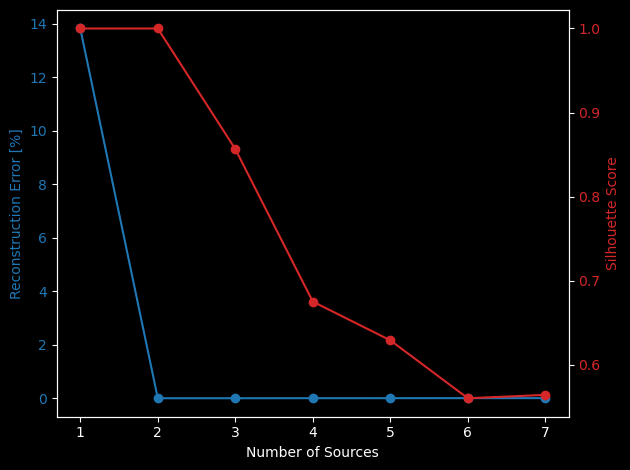

In [ ]:


numsources = good_res.groupby('num_sources', group_keys=False).apply(lambda x: result_analysis(x, observations.size))['num_source'].values
silsall    = good_res.groupby('num_sources', group_keys=False).apply(lambda x: result_analysis(x, observations.size))['sillhouette_score'].values
recs_all   = good_res.groupby('num_sources', group_keys=False).apply(lambda x: result_analysis(x, observations.size))['reconstruction_loss'].values

plot_results_stability_plot(numsources,silsall,recs_all)

In [ ]:
recs_all.shape

(7,)

In [ ]:
good_res.groupby('num_sources', group_keys=False).apply(lambda x: result_analysis(x, observations.size))['centers'].iloc[1]


array([[ 0.70005317, -0.89992474, -0.80001503],
       [ 0.50008913, -0.09986472, -0.19996778]])

In [ ]:
errors

[]

# jax graph analysis

In [ ]:
# # # import tensorflow as tf
# # # from jax.experimental import jax2tf

# # # f_tf = jax2tf.convert(green_matrix)
# # # ff_tf = tf.function(f_tf)

# # # logdir = 'tensorboard-test2/2'
# # # writer = tf.summary.create_file_writer(logdir)
# # # tf.summary.trace_on(graph=True, profiler=True)
# # # ff_tf(As, Xs, Ts, Xd, t, u_scaler, D)
# # # with writer.as_default():
# # #   tf.summary.trace_export(
# # #       name="my_func_trace",
# # #       step=0,
# # #       profiler_outdir=logdir)

# resid = jax.jit(make_flat_resids_fn(model_fn, observations, num_sources))
# flat_init, _ = flatten_inputs(*gen_init(num_sources))
# z=jax.xla_computation(resid)(flat_init)
# graphviz.Source(z.as_hlo_dot_graph())
